In [28]:
import pandas as pd 
import numpy as np
import os, shutil
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, Flatten, MaxPooling2D, BatchNormalization#,Convolution2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.applications import VGG16
from tensorflow.keras.metrics import Recall as recall
from keras import layers, models
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import plot_confusion_matrix, classification_report,confusion_matrix
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

### Business Problem

Pneumonia kills more children than any other infectious disease. Every year it claimes the live of more then 700,000 children under the age of five globally. These deaths are preventable with early diagnostic and treatment.

### Stakeholders

The Doctors Without Borders, who are currently have a mission in Central and West Africa, where according to the UNICEF’s 2019 statistics, the mortality rate for this infection for 5 years old and younger was between 21-24%. They would like to get help in their effort to speed up xray evaluation and detect pneumonia so they can start early treatment to save these lives. Just for comparison this rate in the developed countries runs between 

### Splitting the dataset - shutil images

The kaggle dataset has more then 89% of the images in the train set, 10 % in the test and only 0.3% in the validation, so I will move some of the images from the train folder to the test and validation, to get 70-20-10% split between the 3 folders.
The dataset is imbalance, this I will address this later on with augmentation, to create more images to balance out the .

In [3]:
train_p = "data/chest_xray/train/PNEUMONIA"
train_n = "data/chest_xray/train/NORMAL"
test_p = "data/chest_xray/test/PNEUMONIA"
test_n = "data/chest_xray/test/NORMAL"
val_p = "data/chest_xray/val/PNEUMONIA"
val_n = "data/chest_xray/val/NORMAL"

In [3]:
#images_p = [file for file in os.listdir(train_p) if file.endswith('.jpeg')]

In [4]:
#images_n = [file for file in os.listdir(train_n) if file.endswith('.jpeg')]

In [5]:
# checking images
#images_p[0:10]

In [6]:
#test images pneumonia shutil
#imgs_pneumonia = images_p[:404]
#for img in imgs_pneumonia:
#    origin = os.path.join(train_p, img)
#    destination = os.path.join(test_p, img)
#    shutil.move(origin, destination)

In [7]:
# test images normal shutil
#imgs_normal = images_n[:206]
#for img in imgs_normal:
#    origin = os.path.join(train_n, img)
#    destination = os.path.join(test_n, img)
#    shutil.move(origin, destination)
    

In [8]:
# validation images pneumonia shutil
#imgs_pneumonia = images_p[404:825]
#for img in imgs_pneumonia:
#    origin = os.path.join(train_p, img)
#    destination = os.path.join(val_p, img)
#    shutil.move(origin, destination)

In [9]:
# validation images normal shutil
#imgs_normal = images_n[206:490]
#for img in imgs_normal:
#    origin = os.path.join(train_n, img)
#    destination = os.path.join(val_n, img)
#    shutil.move(origin, destination)

### Preprocessing

In [4]:
# image folder path
train_path = "data/chest_xray/train"
test_path = "data/chest_xray/test"
val_path = "data/chest_xray/val"

In [5]:
# normalizing the images
train_datagen = ImageDataGenerator(rescale=1./255,shear_range=0.2,zoom_range=0.2,horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(rescale = 1.255)

In [6]:
# intentiating the generators for train, test and validation
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(200,200),
    batch_size = 6100,
    color_mode = 'grayscale',
    class_mode = 'categorical')

test_generator = test_datagen.flow_from_directory(
    test_path, 
    target_size = (200, 200),
    batch_size = 1588,
    color_mode = 'grayscale',
    class_mode = 'categorical')

val_generator = test_datagen.flow_from_directory(
    val_path, 
    target_size = (200, 200),
    batch_size = 858,
    color_mode = 'grayscale',
    class_mode = 'categorical')

Found 6100 images belonging to 2 classes.
Found 1588 images belonging to 2 classes.
Found 858 images belonging to 2 classes.


In [18]:
#train_class_names = list(train_generator.class_indices.keys())
#train_class_names

In [7]:
# create the data sets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

In [8]:
# creating the labels for the confusion matrix
test_labels_c = np.argmax(test_labels, axis =-1)

In [9]:
# workaround to plot confusion matrix, seting up the estimator 
labels = list(train_generator.class_indices.keys())
class estimator:
    _estimator_type = ''
    classes_ = []
    def __init__(self, model, classes):
        self.model = model
        self._estimator_type = 'classifier'
        self.classes_ = classes
    def predict(self, X):
        y_prob = self.model.predict(X)
        y_pred = y_prob.argmax(axis=1)
        return y_pred


In [10]:
# Explore the dataset
m_train = train_images.shape[0]
num_px = train_images.shape[1]
m_test = test_images.shape[0]
m_val = val_images.shape[0]

print ("Number of training samples: " + str(m_train))
print ("Number of testing samples: " + str(m_test))
print ("Number of validation samples: " + str(m_val))


Number of training samples: 6100
Number of testing samples: 1588
Number of validation samples: 858


In [11]:
# reshaping label arrays for modeling
train_y = np.reshape(train_labels[:,0], (6100,1))
test_y = np.reshape(test_labels[:,0], (1588,1))
val_y = np.reshape(val_labels[:,0], (858,1))

### Model1

In [41]:
### Ridge regularization
#reg = l2(1e-4)
#reg = l2(3e-3)
reg= l2(1e-6)

In [42]:
# basic sequential model, with adam optimizer, batch normalization and l2 regularization
model1 = Sequential()
# input layer : 64 filters, 4 by 4 shape for each stride, image size 200*200 with 1 chanel for grayscale images, relu activation, ridge regularization, 
model1.add(layers.Conv2D(64, (4,4),input_shape=(200,200,1), activation = 'relu', kernel_regularizer = reg))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(3,3)))

# flatten the model for the dense layer              
model1.add(Flatten())

# fully conected dense layers
model1.add(Dense(64, activation ='relu'))
model1.add(Dense(1, activation = 'sigmoid'))

# compiling the model
model1.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = [recall(),'acc'])

# fitting the model
history1 = model1.fit(train_images, train_y, batch_size = 32, epochs = 50, validation_data = (val_images, val_y))

model1.summary()

Epoch 1/50


2022-12-12 00:28:29.035094: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


191/191 [==============================] - ETA: 0s - loss: 0.7654 - recall_5: 0.8797 - acc: 0.8795

2022-12-12 00:29:00.497815: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


191/191 [==============================] - 35s 182ms/step - loss: 0.7654 - recall_5: 0.8797 - acc: 0.8795 - val_loss: 0.6184 - val_recall_5: 0.9953 - val_acc: 0.5746
Epoch 2/50
191/191 [==============================] - 34s 177ms/step - loss: 0.1578 - recall_5: 0.9361 - acc: 0.9375 - val_loss: 0.3913 - val_recall_5: 0.7855 - val_acc: 0.8438
Epoch 3/50
191/191 [==============================] - 34s 177ms/step - loss: 0.0876 - recall_5: 0.9675 - acc: 0.9667 - val_loss: 0.2081 - val_recall_5: 0.9767 - val_acc: 0.9207
Epoch 4/50
191/191 [==============================] - 34s 177ms/step - loss: 0.0558 - recall_5: 0.9784 - acc: 0.9787 - val_loss: 0.1844 - val_recall_5: 0.9394 - val_acc: 0.9429
Epoch 5/50
191/191 [==============================] - 34s 178ms/step - loss: 0.0217 - recall_5: 0.9941 - acc: 0.9936 - val_loss: 0.2957 - val_recall_5: 0.9907 - val_acc: 0.9161
Epoch 6/50
191/191 [==============================] - 34s 176ms/step - loss: 0.0173 - recall_5: 0.9954 - acc: 0.9943 - val_los

In [44]:
# evaluating model1 train
results_train = model1.evaluate(train_images, train_y)
results_train

191/191 [==============================] - 25s 130ms/step - loss: 4.9209e-06 - recall_5: 1.0000 - acc: 1.0000


[4.920911123917904e-06, 1.0, 1.0]

In [45]:
# evaluating model1 validation
results_val = model1.evaluate(val_images, val_y)
results_val

27/27 [==============================] - 4s 130ms/step - loss: 0.3815 - recall_5: 0.9627 - acc: 0.9569


[0.38153010606765747, 0.9627040028572083, 0.9568764567375183]

In [46]:
# evaluating model1 test
results_test = model1.evaluate(test_images, test_y)
results_test

50/50 [==============================] - 6s 129ms/step - loss: 1.2063 - recall_5: 0.8615 - acc: 0.9093


[1.2063026428222656, 0.8614609837532043, 0.9093199372291565]

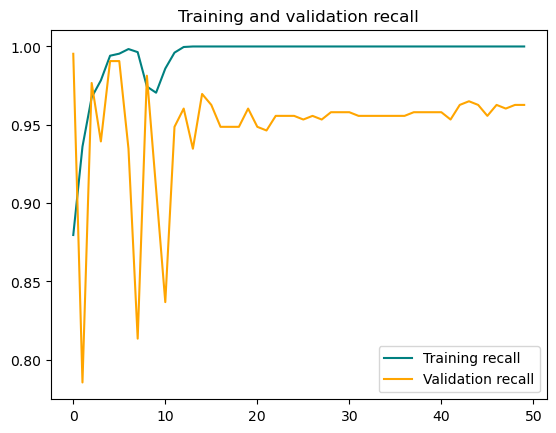

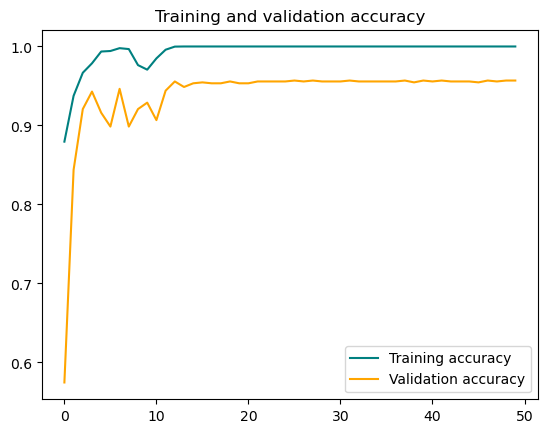

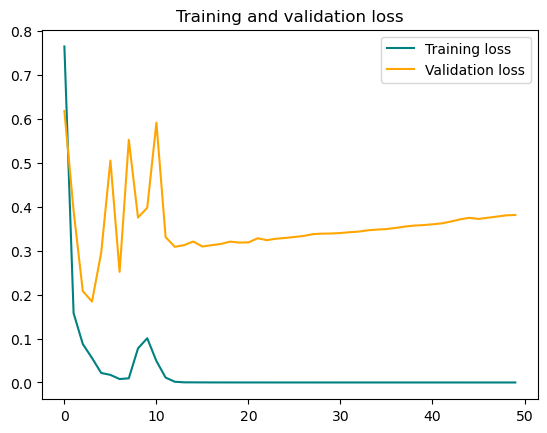

In [47]:
# evaluating model1 recall, accuracy and 
acc = history1.history['acc']
val_acc = history1.history['val_acc']
loss = history1.history['loss']
val_loss = history1.history['val_loss']
epochs = range(len(acc))
epochsv = range(len(loss))
rec = history1.history['recall_5']
val_rec = history1.history['val_recall_5']

epochsr = range(len(rec))

plt.plot(epochsr, rec, color='teal', label= 'Training recall')
plt.plot(epochsr, val_rec, color='orange', label='Validation recall')
plt.title('Training and validation recall')
plt.legend()
plt.figure()

plt.plot(epochs, acc, color='teal', label= 'Training accuracy')
plt.plot(epochs, val_acc, color='orange', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochsv, loss, color='teal', label='Training loss')
plt.plot(epochsv, val_loss, color='orange', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

The first neural networks model is doing pretty well, with high recall score for validation (96.27%) and for the test (86.15%). This is a good result, and it shows that the neural networks model is able to learn from data and generalize well. The high recall score for the validation set suggests that the model is correctly classifing most of the examples in the validation set. 
The validation score and the training score were very high. The loss also decreasing, however the validation loss starts to separate and increase, this might be an indication that the model is overfitting. To stop the model from overfitting I will try to apply regularization in the next model with more Conv2D layer. 


In case the training loss is not decreasing or going weird, it would be time to potentially consider a larger neural network or to make a more sophisticated neural network model. Thankfully this is not the case for my model. As I mentioned earlier the increase in validation loss might be an indicator for overfitting, so I will try to apply the following methods which can help with this: apply regularization, introduce early stopping, hyperparameter tunning, and last but not least increasing the increasing and modifying the images we already have in the training data with some data augmentation.


### Model2 - CNN1

In [19]:
### Ridge regularization
#reg = l2(1e-4)
#reg = l2(3e-3)
reg= l2(1e-6)

In [20]:
# Initializing the CNN
model2 = Sequential()

# 1st convolution layer and pooling
model2.add(layers.Conv2D(32, (3, 3), input_shape=(200, 200, 1), activation = 'relu', kernel_regularizer = reg))
model2.add(MaxPooling2D(pool_size = (3, 3)))

# 2nd convolution layer and pooling
model2.add(layers.Conv2D(32, (3, 3), activation = 'relu'))
model2.add(MaxPooling2D(pool_size = (3, 3)))
model2.add(Dropout(0.3))

# 3rd 
model2.add(layers.Conv2D(64, (3,3), activation ='relu'))
model2.add(MaxPooling2D(pool_size = (3, 3)))

# plattening the layers
model2.add(Flatten())

# adding the fully connected dense layer
model2.add(Dense(64, activation = 'relu'))
#model2.add(Dropout(0.3))
# output layer
model2.add(Dense(1, activation = 'sigmoid')) # is it 1 or 2 for binary classification?

# compiler
model2.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=[recall(), 'acc'])

# earlystop 
# callback in the fit
history2 = model2.fit(train_images,
                        train_y, # changed train_generator and added the train_y
                        batch_size = 32,
                        epochs = 150,
                        validation_data = (val_images, val_y))


Epoch 1/150


2022-12-11 23:11:17.183922: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


191/191 [==============================] - ETA: 0s - loss: 0.4237 - recall_2: 0.8610 - acc: 0.7905

2022-12-11 23:11:22.071639: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


191/191 [==============================] - 6s 27ms/step - loss: 0.4237 - recall_2: 0.8610 - acc: 0.7905 - val_loss: 0.3082 - val_recall_2: 0.7669 - val_acc: 0.8578
Epoch 2/150
191/191 [==============================] - 4s 23ms/step - loss: 0.2672 - recall_2: 0.8816 - acc: 0.8918 - val_loss: 0.1875 - val_recall_2: 0.9464 - val_acc: 0.9301
Epoch 3/150
191/191 [==============================] - 4s 23ms/step - loss: 0.2194 - recall_2: 0.9125 - acc: 0.9159 - val_loss: 0.2090 - val_recall_2: 0.8788 - val_acc: 0.9277
Epoch 4/150
191/191 [==============================] - 4s 23ms/step - loss: 0.1819 - recall_2: 0.9266 - acc: 0.9272 - val_loss: 0.1868 - val_recall_2: 0.9814 - val_acc: 0.9324
Epoch 5/150
191/191 [==============================] - 4s 23ms/step - loss: 0.1635 - recall_2: 0.9334 - acc: 0.9348 - val_loss: 0.1837 - val_recall_2: 0.9837 - val_acc: 0.9382
Epoch 6/150
191/191 [==============================] - 4s 23ms/step - loss: 0.1465 - recall_2: 0.9416 - acc: 0.9430 - val_loss: 0.14

191/191 [==============================] - 5s 24ms/step - loss: 0.0088 - recall_2: 0.9957 - acc: 0.9966 - val_loss: 0.2240 - val_recall_2: 0.9580 - val_acc: 0.9662
Epoch 94/150
191/191 [==============================] - 4s 23ms/step - loss: 0.0104 - recall_2: 0.9964 - acc: 0.9957 - val_loss: 0.2572 - val_recall_2: 0.9254 - val_acc: 0.9534
Epoch 95/150
191/191 [==============================] - 4s 23ms/step - loss: 0.0116 - recall_2: 0.9961 - acc: 0.9957 - val_loss: 0.3725 - val_recall_2: 0.9114 - val_acc: 0.9464
Epoch 96/150
191/191 [==============================] - 4s 23ms/step - loss: 0.0053 - recall_2: 0.9970 - acc: 0.9974 - val_loss: 0.3939 - val_recall_2: 0.9161 - val_acc: 0.9510
Epoch 97/150
191/191 [==============================] - 4s 23ms/step - loss: 0.0014 - recall_2: 0.9993 - acc: 0.9997 - val_loss: 0.2670 - val_recall_2: 0.9510 - val_acc: 0.9557
Epoch 98/150
191/191 [==============================] - 4s 23ms/step - loss: 0.0117 - recall_2: 0.9954 - acc: 0.9952 - val_loss:

191/191 [==============================] - 4s 23ms/step - loss: 0.0018 - recall_2: 0.9997 - acc: 0.9995 - val_loss: 0.3031 - val_recall_2: 0.9394 - val_acc: 0.9580
Epoch 140/150
191/191 [==============================] - 4s 23ms/step - loss: 0.0031 - recall_2: 0.9990 - acc: 0.9990 - val_loss: 0.2686 - val_recall_2: 0.9510 - val_acc: 0.9627
Epoch 141/150
191/191 [==============================] - 4s 23ms/step - loss: 7.7709e-04 - recall_2: 1.0000 - acc: 0.9998 - val_loss: 0.2797 - val_recall_2: 0.9627 - val_acc: 0.9639
Epoch 142/150
191/191 [==============================] - 4s 23ms/step - loss: 0.0111 - recall_2: 0.9964 - acc: 0.9967 - val_loss: 0.4771 - val_recall_2: 0.8928 - val_acc: 0.9312
Epoch 143/150
191/191 [==============================] - 4s 23ms/step - loss: 0.0098 - recall_2: 0.9970 - acc: 0.9967 - val_loss: 0.3329 - val_recall_2: 0.9207 - val_acc: 0.9534
Epoch 144/150
191/191 [==============================] - 4s 23ms/step - loss: 0.0078 - recall_2: 0.9974 - acc: 0.9974 - 

In [21]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 198, 198, 32)      320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 66, 66, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 21, 21, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 21, 21, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 19, 19, 64)       

In [22]:
results_train = model2.evaluate(train_images, train_y)
results_train

191/191 [==============================] - 2s 12ms/step - loss: 0.0042 - recall_2: 0.9977 - acc: 0.9985


[0.004154770169407129, 0.9977049231529236, 0.9985246062278748]

In [23]:
results_val = model2.evaluate(val_images, val_y)
results_val

27/27 [==============================] - 0s 11ms/step - loss: 0.3007 - recall_2: 0.9394 - acc: 0.9499


[0.30073633790016174, 0.939393937587738, 0.9498834609985352]

In [24]:
results_test = model2.evaluate(test_images, test_y)
results_test

50/50 [==============================] - 1s 11ms/step - loss: 0.5917 - recall_2: 0.8778 - acc: 0.9282


[0.5917469263076782, 0.8778337836265564, 0.9282116293907166]

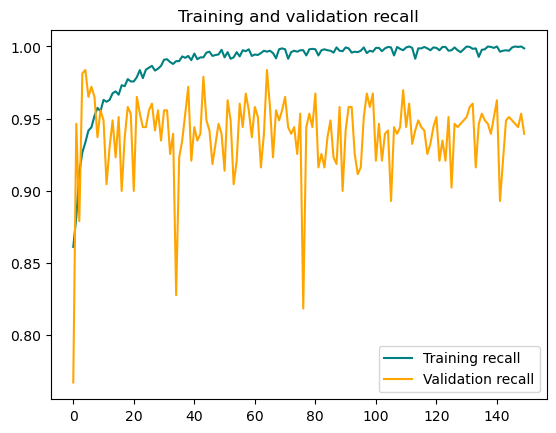

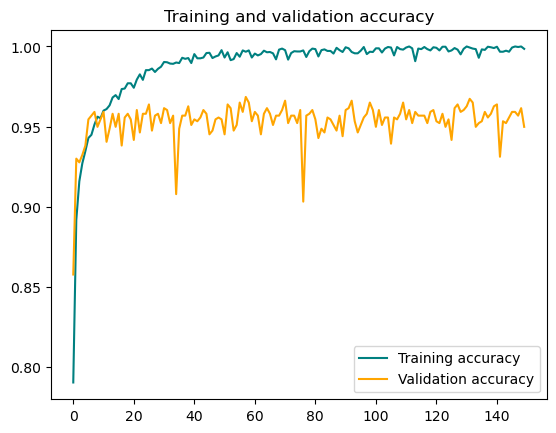

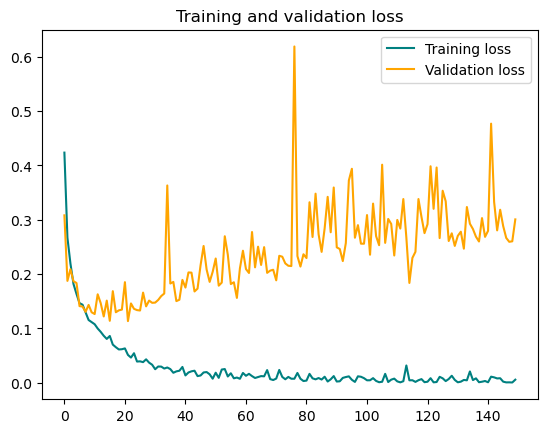

In [35]:
acc = history2.history['acc']
val_acc = history2.history['val_acc']
rec = history2.history['recall_2']
val_rec = history2.history['val_recall_2']
loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochsr = range(len(rec))
epochs = range(len(acc))
epochsv = range(len(loss))

plt.plot(epochsr, rec, color='teal', label= 'Training recall')
plt.plot(epochsr, val_rec, color='orange', label='Validation recall')
plt.title('Training and validation recall')
plt.legend()
plt.figure()
plt.plot(epochs, acc, color='teal', label= 'Training accuracy')
plt.plot(epochs, val_acc, color='orange', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochsv, loss, color='teal', label='Training loss')
plt.plot(epochsv, val_loss, color='orange', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

I applied an Ridge regularization of  `l2(1e-6)`.
The training recall and the validation recall still not converging. There are still an oscillation in both. The validation recall is 93.94% , and the test is 87,78%. 
As a next step I will change the L2 regularization and add early stopping to the model. I will also try to run it with a larger epoch size (200) and change the L2 regularization to control the models complexity, thus prevent it from overfitting. In addition I will also apply early stopping with a patience of 10 on the validation loss.

### Model3 - CNN2 with L2 regularization and Early Stopping

In [26]:
### Ridge regularization
reg = l2(1e-4)
#reg = l2(3e-3)
#reg= l2(1e-6)

In [29]:
# Initializing the CNN
model3 = Sequential()

# 1st convolution layer and pooling
model3.add(layers.Conv2D(128, (3, 3), input_shape=(200, 200, 1), activation = 'relu', kernel_regularizer = reg))
model3.add(MaxPooling2D(pool_size = (3, 3)))

# 2nd convolution layer and pooling
model3.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
model3.add(MaxPooling2D(pool_size = (3, 3)))
model3.add(Dropout(0.2))

# 3rd 
model3.add(layers.Conv2D(64, (3,3), activation ='relu'))
model3.add(MaxPooling2D(pool_size = (3, 3)))

# 4th 
model3.add(layers.Conv2D(32, (3,3), activation ='relu'))
model3.add(MaxPooling2D(pool_size = (3, 3)))

# plattening the layers
model3.add(Flatten())

# adding the fully connected dense layer
model3.add(Dense(64, activation = 'relu'))
#model2.add(Dropout(0.1))
# output layer
model3.add(Dense(1, activation = 'sigmoid'))

# compiler
model3.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=[recall(), 'acc'])

# fit the model
history3 = model3.fit(train_images,
                        train_y,
                        batch_size = 16,
                        epochs = 200,
                        validation_data = (val_images, val_y),
                        callbacks = [early_stopping])

Epoch 1/300


2022-12-11 23:34:38.272746: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


191/191 [==============================] - ETA: 0s - loss: 0.5297 - recall_3: 0.7666 - acc: 0.7133

2022-12-11 23:34:50.595135: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


191/191 [==============================] - 14s 69ms/step - loss: 0.5297 - recall_3: 0.7666 - acc: 0.7133 - val_loss: 0.3988 - val_recall_3: 0.6807 - val_acc: 0.8054
Epoch 2/300
191/191 [==============================] - 11s 58ms/step - loss: 0.3183 - recall_3: 0.8377 - acc: 0.8620 - val_loss: 0.3946 - val_recall_3: 0.6364 - val_acc: 0.8089
Epoch 3/300
191/191 [==============================] - 11s 58ms/step - loss: 0.2521 - recall_3: 0.8813 - acc: 0.8941 - val_loss: 0.2399 - val_recall_3: 0.8858 - val_acc: 0.9068
Epoch 4/300
191/191 [==============================] - 11s 58ms/step - loss: 0.2166 - recall_3: 0.8993 - acc: 0.9103 - val_loss: 0.2347 - val_recall_3: 0.8485 - val_acc: 0.9068
Epoch 5/300
191/191 [==============================] - 11s 58ms/step - loss: 0.1946 - recall_3: 0.9115 - acc: 0.9190 - val_loss: 0.1802 - val_recall_3: 0.9371 - val_acc: 0.9359
Epoch 6/300
191/191 [==============================] - 11s 59ms/step - loss: 0.1627 - recall_3: 0.9275 - acc: 0.9325 - val_loss

In [30]:
results_train = model3.evaluate(train_images, train_y)
results_train

191/191 [==============================] - 5s 22ms/step - loss: 0.0375 - recall_3: 0.9784 - acc: 0.9887


[0.03750944510102272, 0.978360652923584, 0.9886885285377502]

In [31]:
results_val = model3.evaluate(val_images, val_y)
results_val

27/27 [==============================] - 1s 22ms/step - loss: 0.2302 - recall_3: 0.9114 - acc: 0.9371


[0.23018981516361237, 0.9114219546318054, 0.9370629787445068]

In [32]:
results_test = model3.evaluate(test_images, test_y)
results_test

50/50 [==============================] - 1s 21ms/step - loss: 0.3246 - recall_3: 0.8627 - acc: 0.9194


[0.3246440291404724, 0.8627204298973083, 0.9193955063819885]

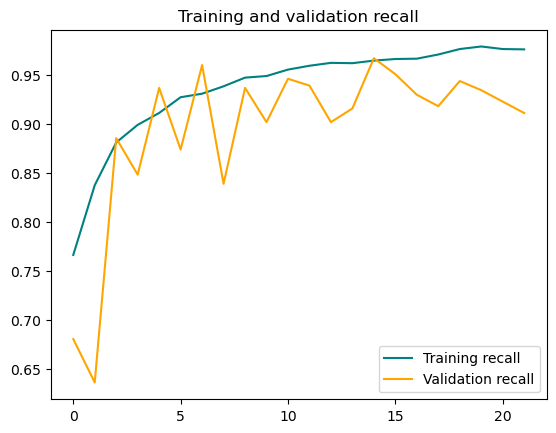

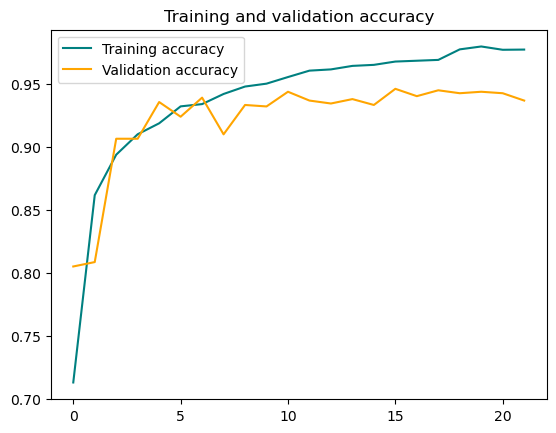

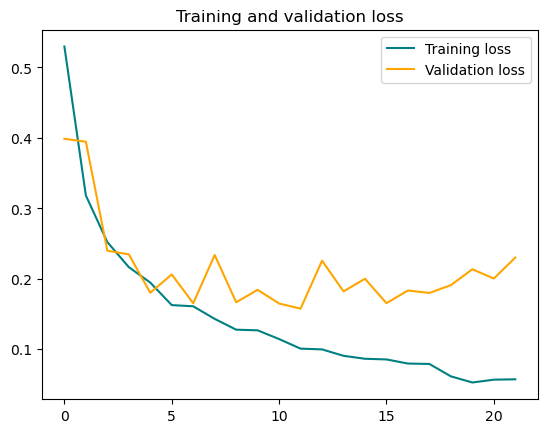

In [34]:
# plot model3 scores
acc = history3.history['acc']
val_acc = history3.history['val_acc']
rec = history3.history['recall_3']
val_rec = history3.history['val_recall_3']
loss = history3.history['loss']
val_loss = history3.history['val_loss']
epochsr = range(len(rec))
epochs = range(len(acc))
epochsv = range(len(loss))

plt.plot(epochsr, rec, color='teal', label= 'Training recall')
plt.plot(epochsr, val_rec, color='orange', label='Validation recall')
plt.title('Training and validation recall')
plt.legend()
plt.figure()
plt.plot(epochs, acc, color='teal', label= 'Training accuracy')
plt.plot(epochs, val_acc, color='orange', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochsv, loss, color='teal', label='Training loss')
plt.plot(epochsv, val_loss, color='orange', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

The early stopping with a patience of 10 did stop the model after the 22nd epochs.
The test recall is 86.27% and the validation is 91,14%. Which is still good. The loss starts to separate and increase over 10 epochs. In general you want to see the loss decreasing steadily and the accuracy increasing for both the train and validation.

To increase the dataset and to prevent overfitting besides handling the data imbalance, I will try data augmentation. With small transformations such as rotating the images and zooming in on them, we can increase the number of images in our dataset.  


In [ ]:
#ImageDataGenerator??

### Data Augmentation

In [49]:
# generating more data with ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255, 
                                  rotation_range = 40,
                                  width_shift_range = 0.2,
                                  height_shift_range = 0.2,
                                  shear_range = 0.3,
                                  zoom_range = 0.2,
                                  horizontal_flip=True)

#train_datagen.fit(train_images)

Data Augmentation allows to add more data to the training set, similar to the data we just had but it is reasonably modified to some degrees so it’s not exactly the same.
I used the following data augmentation arguments: 
- rescaling the images after transformation 
- rotation_range:  rotating images by 40 degrees 
- width_shift_range: shifting images horizontally (by 0.2 of total width) 
- height_shift_range: shifting images vertically(by 0.2 of total height) 
- shear_range: shear angle by 30 degrees 
- zoom_range: zoom images by 20% 
- horizontal_flip: flip images horizontally

names = [os.path.join(train_n, name) for name in os.listdir(train_n)]
names

# loop through each image in the normal train folder
for i in names:
    if i.endswith('.jpeg'):
        # open up each image
        img = Image.open(i)
        # make it into an array
        arr = img_to_array(img)
        # reshape the input image
        arr = arr.reshape((1, ) + arr.shape)
        n = 0
        # creating the new images 
        for m in train_datagen.flow(arr, batch_size = 1,
                                   save_to_dir = './data/chest_xray/train/NORMAL',
                                   save_prefix = 'augmented -', save_format = 'jpeg'):
            n += 1
            if n > 3:
                break

# loop through each image in the normal test folder and augment some more images 
names_test = [os.path.join(test_n, name) for name in os.listdir(test_n)]
names_test

# loop through each image in the normal train folder
for i in names_test:
    if i.endswith('.jpeg'):
        # open up each image
        img = Image.open(i)
        # make it into an array
        arr = img_to_array(img)
        # reshape the input image
        arr = arr.reshape((1, ) + arr.shape)
        n = 0
        # creating the new images 
        for m in train_datagen.flow(arr, batch_size = 1,
                                   save_to_dir = './data/test_aug/normal',
                                   save_prefix = 'augmented -', save_format = 'jpeg'):
            break

# creating new images for the validation normal 
names_val = [os.path.join(val_n, name) for name in os.listdir(val_n)]
names_val

for i in names_val:
    if i.endswith('.jpeg'):
        # open up each image
        img = Image.open(i)
        # make it into an array
        arr = img_to_array(img)
        # reshape the input image
        arr = arr.reshape((1, ) + arr.shape)
        n = 0
        # creating the new images 
        for m in train_datagen.flow(arr, batch_size = 1,
                                   save_to_dir = './data/val_aug/normal',
                                   save_prefix = 'aug-', save_format = 'jpeg'):
            break


### Model4 -Augmented CNN with L2 regularization, BatchNormalization and Dropout

In [36]:
model4 = Sequential()
#1st conv layer
model4.add(layers.Conv2D(32, (3, 3),strides = 1, padding='same', activation='relu',kernel_regularizer = reg,
                        input_shape=(200 ,200,  1)))
model4.add(BatchNormalization())
model4.add(layers.MaxPooling2D((2, 2), strides = 2, padding ='same'))

#2nd conv layer
model4.add(layers.Conv2D(64, (3, 3), strides = 1, padding = 'same', activation='relu'))
model4.add(Dropout(0.1))
model4.add(BatchNormalization())
model4.add(layers.MaxPooling2D((2, 2), strides = 2, padding = 'same'))

#3rd conv layer
model4.add(layers.Conv2D(64, (3, 3),strides = 1, padding = 'same', activation='relu'))
model4.add(layers.MaxPooling2D((2, 2),strides = 2, padding = 'same'))

# 4th conv layer
model4.add(layers.Conv2D(64, (3, 3),strides = 1, padding = 'same', activation='relu'))
model4.add(Dropout(0.1))
model4.add(BatchNormalization())
model4.add(layers.MaxPooling2D((2, 2),strides = 2, padding = 'same'))

model4.add(layers.Flatten())
model4.add(layers.Dense(64, activation='relu'))#, kernel_regularizer = reg))
model4.add(layers.Dense(1, activation='sigmoid'))

adam = tf.keras.optimizers.Adam(learning_rate = 0.01)
model4.compile(loss='binary_crossentropy',
              optimizer= adam,
              metrics=[recall(), 'acc'])

# fitting model 4
history4 = model4.fit(train_images,
                        train_y,
                        batch_size = 32,
                        epochs = 200,
                        validation_data = (val_images, val_y),
                        callbacks = [early_stopping])

model4.summary()

Epoch 1/200


2022-12-12 00:10:19.974078: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


191/191 [==============================] - ETA: 0s - loss: 0.7654 - recall_4: 0.6056 - acc: 0.7564

2022-12-12 00:10:30.484132: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


191/191 [==============================] - 11s 54ms/step - loss: 0.7654 - recall_4: 0.6056 - acc: 0.7564 - val_loss: 7.1104 - val_recall_4: 0.0000e+00 - val_acc: 0.5000
Epoch 2/200
191/191 [==============================] - 9s 48ms/step - loss: 0.2205 - recall_4: 0.9289 - acc: 0.9100 - val_loss: 1.1257 - val_recall_4: 0.2401 - val_acc: 0.6189
Epoch 3/200
191/191 [==============================] - 9s 46ms/step - loss: 0.1863 - recall_4: 0.9380 - acc: 0.9241 - val_loss: 0.2713 - val_recall_4: 0.8718 - val_acc: 0.9266
Epoch 4/200
191/191 [==============================] - 9s 47ms/step - loss: 0.1499 - recall_4: 0.9482 - acc: 0.9430 - val_loss: 1.1595 - val_recall_4: 0.3403 - val_acc: 0.6702
Epoch 5/200
191/191 [==============================] - 9s 47ms/step - loss: 0.1387 - recall_4: 0.9541 - acc: 0.9451 - val_loss: 2.1690 - val_recall_4: 0.1305 - val_acc: 0.5618
Epoch 6/200
191/191 [==============================] - 9s 46ms/step - loss: 0.1320 - recall_4: 0.9584 - acc: 0.9495 - val_loss:

 dropout_3 (Dropout)         (None, 25, 25, 64)        0         
                                                                 
 batch_normalization_4 (Batc  (None, 25, 25, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 13, 13, 64)       0         
 g2D)                                                            
                                                                 
 flatten_4 (Flatten)         (None, 10816)             0         
                                                                 
 dense_8 (Dense)             (None, 64)                692288    
                                                                 
 dense_9 (Dense)             (None, 1)                 65        
                                                                 
Total params: 785,665
Trainable params: 785,345
Non-trainable params: 320
__

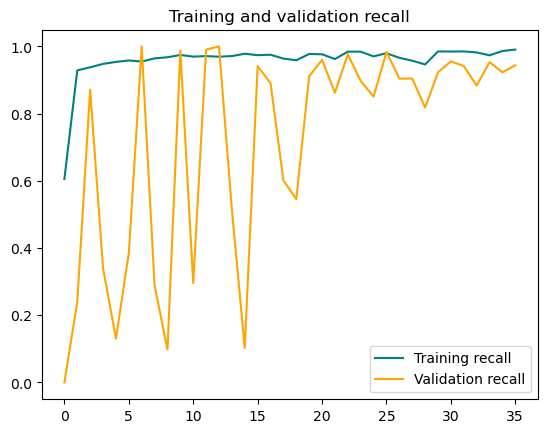

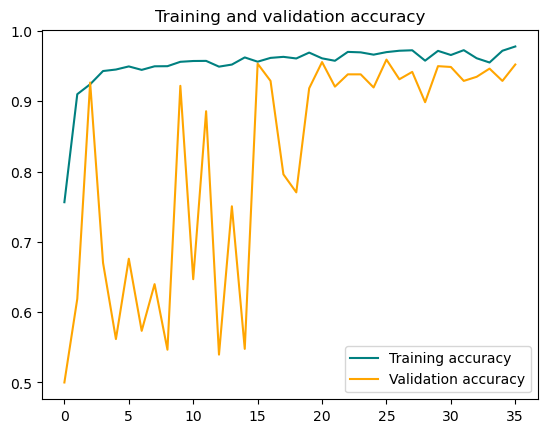

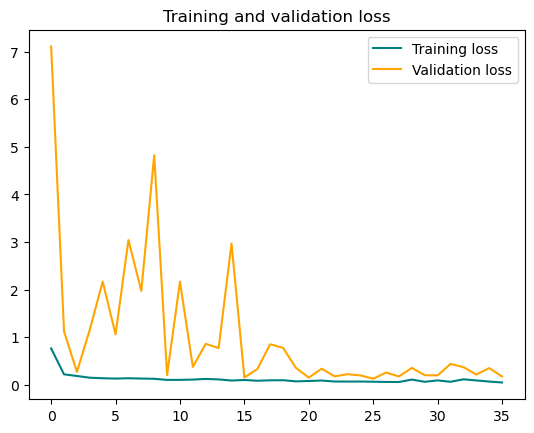

In [37]:
# creating visualization
acc = history4.history['acc']
val_acc = history4.history['val_acc']
rec = history4.history['recall_4']
val_rec = history4.history['val_recall_4']
loss = history4.history['loss']
val_loss = history4.history['val_loss']
epochs = range(len(acc))
epochsr = range(len(rec))
epochsv = range(len(loss))

plt.plot(epochs, rec, color='teal', label= 'Training recall')
plt.plot(epochs, val_rec, color='orange', label='Validation recall')
plt.title('Training and validation recall')
plt.legend()
plt.figure()
plt.plot(epochs, acc, color='teal', label= 'Training accuracy')
plt.plot(epochs, val_acc, color='orange', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, color='teal', label='Training loss')
plt.plot(epochs, val_loss, color='orange', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Model4 does not perform that well. There is a fluctuation in the  recall. The validation score is 94.40% and the test score is 86.02% . The loss is approaching zero after 20 epochs. The early stopping stop the model at 36 epochs.

In [38]:
results_train = model4.evaluate(train_images, train_y)
results_train

191/191 [==============================] - 3s 17ms/step - loss: 0.0468 - recall_4: 0.9816 - acc: 0.9798


[0.04676535725593567, 0.9816393256187439, 0.9798360466957092]

In [39]:
results_val = model4.evaluate(val_images, val_y)
results_val

27/27 [==============================] - 0s 15ms/step - loss: 0.1759 - recall_4: 0.9441 - acc: 0.9522


[0.17590372264385223, 0.94405597448349, 0.9522144794464111]

In [40]:
results_test = model4.evaluate(test_images, test_y)
results_test

50/50 [==============================] - 1s 15ms/step - loss: 0.5000 - recall_4: 0.8602 - acc: 0.9175


[0.5000172853469849, 0.8602015376091003, 0.9175063371658325]

### Evaluation

Best Model Results:
Model1
* `Test Recall: `  86.14%
* `Test Accuracy: ` 96.27%

This model only has 1 convolution layer with L2 regularization, BatchNormalization and two dense layers. It has high accuracy and high recall scores, which indicates that the model can correctly identify whether a patient has pneumonia or not.

### Conclusion

Model1 performed the best out of all the models. It only had 1 convolution layer with L2 regularization, BatchNormalization and two dense layers.
In the Conv2D with 64 layers,  I used relu optimizer and Ridge regularization of l2(1e-6) with relu and sigmoid optimizer and loss set to binary crossentrophy. After fitting the model I used the batch size of 32 with 50 epochs.

The selected model has high accuracy and high recall scores, which indicates that the model can correctly identify whether a patient has pneumonia or not after checking the X-Ray images.
With this model any organization would cut down on time spent evaluating these images, it would also speed up the process of diagnostic, which would lead more availably doctors for the patients and after diagnosis they could start early treatment. Which would directly lead to more pediatric patient recovering from this infection and this also decreases the mortality rate.
